# Assignment 3

**Task**: forecast the real price of gasoline for the US

**Dataset**: gasoline.xlsx contains two monthly time series. The nomial price of gasoline and the CPI

In [139]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib import style
import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf
import math
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error as mse

plt.style.use('mystyle.mplstyle')

In [2]:
def make_a_line():
    ax.plot([0.12, .9],                  # Set width of line
        [1.05, 1.05],                  # Set height of line
        transform=fig.transFigure,   # Set location relative to plot
        clip_on=False, 
        color='#E3120B', 
        linewidth=.6)
def make_a_rec():
    ax.add_patch(plt.Rectangle((0.12,1.05),                 # Set location of rectangle by lower left corder
                           0.04,                       # Width of rectangle
                           -0.02,                      # Height of rectangle. Negative so it goes down.
                           facecolor='#E3120B', 
                           transform=fig.transFigure, 
                           clip_on=False, 
                           linewidth = 0))
    
def make_title(text):
    ax.text(x=0.12, y=0.98, s=text, 
            transform=fig.transFigure, ha='left', 
            fontsize=13, weight='bold', alpha=.8)
    
def make_description(text):
    ax.text(x=0.12, y=0.93, s=text, 
            transform= fig.transFigure, ha='left', 
            fontsize=11, alpha=.8)
    
def plot(title, text):
    make_a_line()
    make_a_rec()
    make_title(title)
    make_description(text)

In [189]:
df = pd.read_excel("gasoline.xls", index_col= 0)
df.columns = ['nominal_price', 'cpi']
df.index.freq = "MS"

## 1) Real Price of Gasoline

In [190]:
df['real_price'] = (df['nominal_price']/df['cpi'])*100

## 2) Plot Real and Nominal Prices

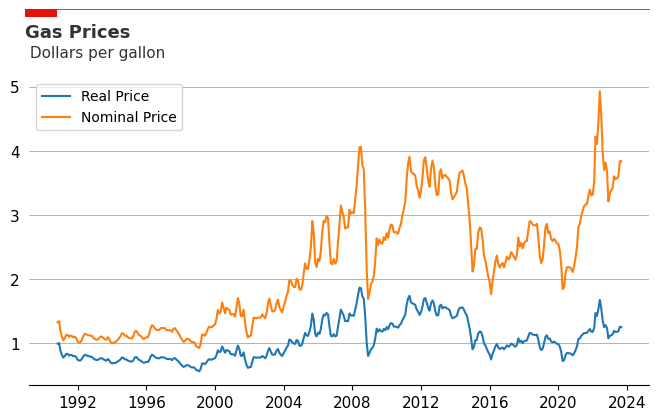

In [191]:
fig, ax = plt.subplots()

ax.plot(df.index, df.real_price, zorder = 2, label = 'Real Price')
ax.plot(df.index, df.nominal_price, zorder = 2, label = 'Nominal Price')
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plot('Gas Prices'," Dollars per gallon")
#plt.savefig('GDP.png')

## 3) ACF

We will now on work with logs

In [192]:
df['log_real_price'] = np.log(df.real_price)
df['log_nominal_price'] = np.log(df.nominal_price)
df['delta_real'] = (df['real_price'] - df['real_price'].shift(1))
df['delta_real'].fillna(0, inplace = True)

In [193]:
dtrain = df[:'2014-12-01']
dtest = df['2015-01-01':]

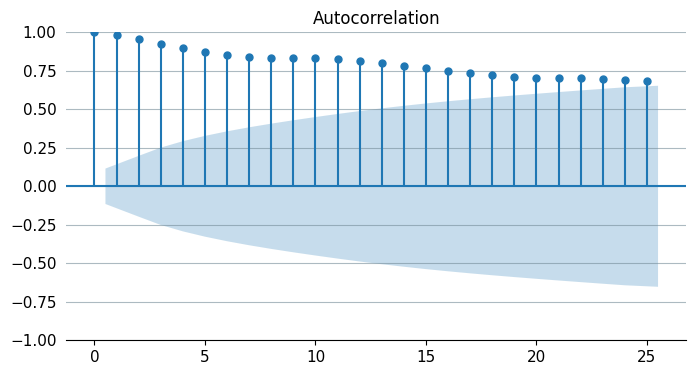

In [195]:
plot_acf(dtrain.log_real_price);

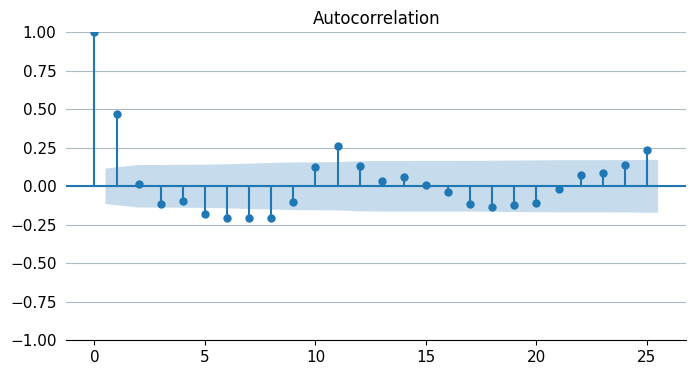

In [196]:
plot_acf(dtrain.delta_real);

## 4) AR(1)

In [197]:
price_ar1model = ARIMA(dtrain.log_real_price, order = (1,0,0))
price_ar1results = price_ar1model.fit()

print(price_ar1results.summary())

                               SARIMAX Results                                
Dep. Variable:         log_real_price   No. Observations:                  290
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 427.579
Date:                Wed, 08 Nov 2023   AIC                           -849.158
Time:                        16:19:35   BIC                           -838.149
Sample:                    11-01-1990   HQIC                          -844.747
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0271      0.231     -0.117      0.907      -0.479       0.425
ar.L1          0.9845      0.011     88.819      0.000       0.963       1.006
sigma2         0.0030      0.000     20.503      0.0

In [198]:
delta_ar1model = ARIMA(dtrain.delta_real, order = (1,0,0))
delta_ar1results = delta_ar1model.fit()

print(delta_ar1results.summary())

                               SARIMAX Results                                
Dep. Variable:             delta_real   No. Observations:                  290
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 426.367
Date:                Wed, 08 Nov 2023   AIC                           -846.733
Time:                        16:19:39   BIC                           -835.724
Sample:                    11-01-1990   HQIC                          -842.322
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.007     -0.028      0.977      -0.013       0.013
ar.L1          0.4782      0.030     15.687      0.000       0.418       0.538
sigma2         0.0031      0.000     18.453      0.0

## 5) FORECASTS

In [199]:
def forecast(a, b, c): 
    
    forecasts_log = pd.Series(dtype = 'float64')

    initial_span = len(dtrain.index) 

    current_span = initial_span

    for t in range(len(dtest.index)):

        current_window = df.iloc[:current_span]

        model = ARIMA(current_window.log_real_price, order = (a, b, c))
        results = model.fit()

        forecast = results.forecast(steps=1)

        forecasts_log = pd.concat([forecasts_log, forecast])

        current_span += 1

    forecasts = np.exp(forecasts_log)

    return forecasts
        

### 5.1) Random walk 

In [200]:
random_walk_forecasts = forecast(1,0,0)

### 5.2) ARIMA (1,1,0)

In [201]:
arima_110 = forecast(1,1,0)


c:\Users\tifos\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\tifos\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 5.3) ARIMA(0,1,1)

In [202]:
arima_011 = forecast(0,1,1)

c:\Users\tifos\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\tifos\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 5.4) ARIMA(1,1,1)

In [203]:
arima_111 = forecast(1,1,1)

c:\Users\tifos\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\tifos\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 6) Mean Squared Forecast Error

In [209]:
mse_rw = mse(dtest.real_price, random_walk_forecasts)
mse_arima_110 = mse(dtest.real_price, arima_110)
mse_arima_011 = mse(dtest.real_price, arima_011)
mse_arima_111 = mse(dtest.real_price, arima_111)

In [211]:
mse_arima_011

0.0038086097746155415